In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./train_shuffled_16features.csv')

In [3]:
# NUM_SAMPLES = 300
NUM_SAMPLES = 50

rpm = df['ENGINE_RPM'][:NUM_SAMPLES]
load = df['ENGINE_LOAD'][:NUM_SAMPLES]
y = df['MAF'][:NUM_SAMPLES] / 14.7 / 1000 # mass fuel flow rate [kg/s]

In [4]:
rpm2 = rpm.apply(lambda x: np.power(x, 2))
rpm3 = rpm.apply(lambda x: np.power(x, 3))
load2 = load.apply(lambda x: np.power(x, 2))
rpm_load = rpm * load
rpm2_load = rpm2 * load
rpm_load2 = rpm * load2
rpm3_load = rpm3 * load
rpm2_load2 = rpm2 * load2

In [5]:
# given a linear function y = Xw, where y are outcomes, X is the feature matrix, w is a vector of weights (i.e. model parameters)
# assume X^-1 (the inverse matrix of X)exists, we can use it to solve for w, namely w = X^-1y 
# L2 : m˙ f = α1ω + α2ωτ + α3ω^2 τ + α4ω^3 τ + α5ωτ^2 +α6ω^2τ^2 
# L3 : m˙ f = α1ω + α2ω^2 + α3ω^3 + α4ωτ + α5ω^2 τ +α6ωτ^2.
# iven α the model parameters, ω the engine speed (rpm), and τ the engine load.

L2 = np.concatenate((np.matrix(rpm).T, np.matrix(rpm_load).T, np.matrix(rpm2_load).T, np.matrix(rpm3_load).T, np.matrix(rpm_load2).T, np.matrix(rpm2_load2).T), axis=1) #L2

L3 = np.concatenate((np.matrix(rpm).T, np.matrix(rpm2).T, np.matrix(rpm3).T, np.matrix(rpm_load).T, np.matrix(rpm2_load).T, np.matrix(rpm_load2).T), axis=1) #L3


In [6]:
# weights of the linear function
# applying formula w = X^-1y using pseudo inverse
L2 = np.dot(np.linalg.pinv(L2), y)
L3 = np.dot(np.linalg.pinv(L3), y)
print(L2)
print(L3)

[[ 2.52513323e-08  1.09423839e-08 -1.95654143e-12  2.35310323e-16
  -3.47429286e-11  3.01553464e-14]]
[[ 8.37910605e-08 -5.42690802e-11  9.86735175e-15  7.30706560e-09
   7.24154734e-13  1.49685479e-11]]


Text(0, 0.5, 'fuel rate')

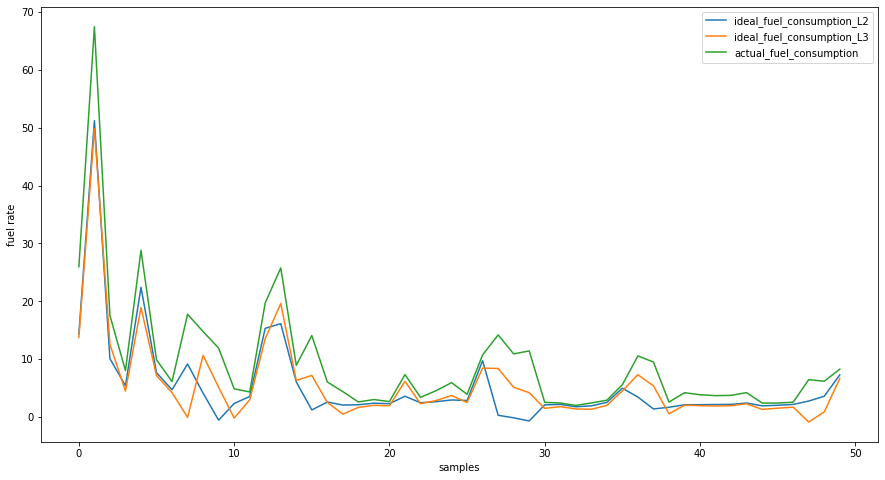

In [7]:
# predict ideal fuel consumptions
optimal_L2 = []
optimal_L3 = []

for i in range(0, NUM_SAMPLES):
   mfr_L2 = (L2[0, 0] * rpm[i] + L2 [0, 1] * rpm_load[i] + L2 [0, 2]  * rpm2_load[i] - 
         L2[0, 3]* rpm3_load[i] + L2[0, 4] * rpm_load2[i] - L2[0, 5] * rpm2_load2[i]) 
         
   mfr_L3 = (L3[0, 0] * rpm[i] + L3[0, 1] * rpm2[i] - L3[0, 2] * rpm3[i] + 
         L3[0, 3] * rpm_load[i] - L3[0, 4] * rpm2_load[i] + L3[0, 5] * rpm_load2[i]) 
   optimal_L2.append(mfr_L2)
   optimal_L3.append(mfr_L3)

ideal_fuel_rate_L2 = pd.Series(map(lambda x: x * (3600 / 820) * 1000, optimal_L2)) # fuel flow rate [l/h]
ideal_fuel_rate_L3 = pd.Series(map(lambda x: x * (3600 / 820) * 1000, optimal_L3)) # fuel flow rate [l/h]
actual_fuel_rate = df['FUEL_RATE'][:NUM_SAMPLES] # fuel flow rate [l/h]
ideal_fuel_consumption_L2 = (ideal_fuel_rate_L2 / df['SPEED'][:NUM_SAMPLES]) * 100 # fuel consumption [l/km]
ideal_fuel_consumption_L3 = (ideal_fuel_rate_L3 / df['SPEED'][:NUM_SAMPLES]) * 100 # fuel consumption [l/km]
actual_fuel_consumption = (actual_fuel_rate / df['SPEED'][:NUM_SAMPLES]) * 100 # fuel consumption [l/km]
 
fig, ax = plt.subplots()
ideal_fuel_consumption_L2.plot(figsize=[15,8], ax = ax)
ideal_fuel_consumption_L3.plot(figsize=[15,8], ax = ax)
actual_fuel_consumption.plot(ax = ax)
plt.legend(["ideal_fuel_consumption_L2", "ideal_fuel_consumption_L3", "actual_fuel_consumption"])
# plt.legend(["ideal_fuel_consumption_L3", "actual_fuel_consumption"])
plt.xlabel('samples')
plt.ylabel('fuel rate')